In [92]:
import numpy as np
import torch 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pickle
import re

latex_textwidth_in_inches = 6.5  # change as needed
px_width = latex_textwidth_in_inches * 96
template = "simple_white"
font=dict(family="Times New Roman", size=11)
default_colors = ['Black'] + px.colors.qualitative.T10 + px.colors.qualitative.Plotly + px.colors.qualitative.Antique
figure_path = r"C:\Users\Noahc\Documents\USYD\PHD\4 - Latex_new\00_figures\06_mno\circle"

import sys
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909')
from utilities import PCA
from utils.mesh_utils import BatchedAngularMeshRavel

In [23]:
# For 3D PCA scatter plots
pca_scene_dict = {'aspectmode':"manual", 
              'aspectratio':{'x':1,'y':1,'z':1.5},
              'xaxis':{'title':"1st PC"},
              'yaxis':{'title':"2nd PC"},
              'zaxis':{'title':"t"},}
pca_scene_camera = {'projection':{'type':"orthographic"},
                'up':{'x':0,'y':0,'z':1},
                'eye':{'x':0.5,'y':0.5,'z':0.5},
                'center':{'x':0.1,'y':0,'z':-0.1}
    }

In [24]:
dataset_path = r"C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\RAS_Re100k.npy"
#re500_path = r"C:/Users/Noahc/Documents/USYD/PHD/0 - Work Space/Markov Studies v2/2D_NS_Re500_sample.npy"
dataset = np.load(dataset_path)[100:,...,:2]
print(f'Dataset has shape {dataset.shape}')

Dataset has shape (801, 21004, 2)


In [ ]:
models = {'Dataset':{'data': torch.tensor(dataset)},
          #'H1_xy1_vw1':{'wandb_name': "rare-sweep-3"},
          #'H1_xy0_vw1':{'wandb_name': "faithful-sweep-9"},
          #'H1_xy1_vw0':{'wandb_name': "divine-sweep-4"},
          'H1_xy0_vw0':{'wandb_name': "flowing-sweep-10"},
          'H0_xy0':{'wandb_name': "good-sweep-12"},
          'H0_xy1':{'wandb_name': "light-sweep-6"},
          }

sweep_path1 = r'C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports'

# Quick dirty, do the whole sweep folder
sweep_name = "SWEEP-sty6240b"
if sweep_name is not None:
    from pathlib import Path
    dir_path = Path(sweep_path1+"/"+sweep_name)
    sweep_run = [
        p.name.rsplit("-", 1)[0]
        for p in dir_path.iterdir()
        if p.is_dir()
    ]
    for name in sweep_run:
        models[name] = {'wandb_name': name}
        
for key,__ in models.items():
    models[key]['name'] = re.sub(r"H([0-2])", r"H<sub>\1</sub>", key).replace("_"," ")

In [26]:
coord_points = np.load(dataset_path[:-4]+'_coords.npy')
Ravler = BatchedAngularMeshRavel(coord_points,m=59,n=356, device='cpu')

In [27]:
import os
from pathlib import Path
def fetch_results_path(models, level1_path=None, dictkey='wandb_name'):
    if level1_path is None:
        level1_path = os.getcwd()
        print(f'Searching for model exports in {level1_path}')
    level1_path = Path(level1_path)
    
    for key, value in models.items():
        if key == 'Dataset': continue
        run_path = None
        #wandb_name = value[dictkey].copy()

        for folder in level1_path.iterdir():
            if folder.is_dir() and folder.name.startswith(value[dictkey]):
                run_path = folder
                break
        
        if run_path is None:
            for level2_path in level1_path.iterdir():
                level2_path = Path(level2_path)
                if level2_path.is_dir():
                    for folder in level2_path.iterdir():
                        if folder.is_dir() and folder.name.startswith(value[dictkey]):
                            run_path = folder
                            break
        
        if run_path is None:
            print(f'{key} not found :(')
        else:
            models[key]['run_path'] = run_path
            print(f'{key} found at {run_path}')

In [69]:
solution_filename = 'long_rollout_10000.npy.npy'
fetch_results_path(models, level1_path=sweep_path1)
for key, value in models.items():
    try:
        models[key]['data'] = Ravler.to(torch.tensor(np.load(f'{value["run_path"]}/{solution_filename}')),forward=False)
        T = models[key]["data"].shape[0] # set T for total study
        print(f'{key} has solution size {models[key]["data"].shape}')
    except:
        print(f'{key} has no solution path')

H1_xy0_vw0 found at C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports\SWEEP-5vnp53x5\flowing-sweep-10-oxifl2m5
H0_xy0 found at C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports\SWEEP-5vnp53x5\good-sweep-12-lkywxnm4
H0_xy1 found at C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports\SWEEP-5vnp53x5\light-sweep-6-okq7gw2e
dauntless-sweep-10 found at C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports\SWEEP-sty6240b\dauntless-sweep-10-ut7tyge6
denim-sweep-4 found at C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports\SWEEP-sty6240b\denim-sweep-4-8jnnmd8b
genial-sweep-12 found at C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports\SWEEP-sty6240b\genial-sweep-12-5du6unb6
hardy-sweep-6 found at C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Markov Studies v2\Cylinder\exports\SWEEP-sty6240b\hardy-sw

### PCA Statistics

In [70]:
use_preloaded_encoding = True
save_new_encoding = False
encoding_folder = r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Rev909\data'

PCA_dim = 50
if use_preloaded_encoding:
    with open(f"{encoding_folder}/x_pca_cylinder_velmag.pkl", "rb") as f:
        x_pca = pickle.load(f)
else:
    x_pca = PCA(torch.tensor(np.sqrt(dataset[...,0]**2 + dataset[...,0]**2)), PCA_dim, subtract_mean=False)
    if save_new_encoding:
        with open(f"{encoding_folder}/x_pca_cylinder_velmag.pkl", "wb") as f:
            pickle.dump(x_pca, f)

for key, value in models.items():
    models[key]['pca_encoding'] = x_pca.encode(np.sqrt(value['data'][...,0]**2 + value['data'][...,1]**2))

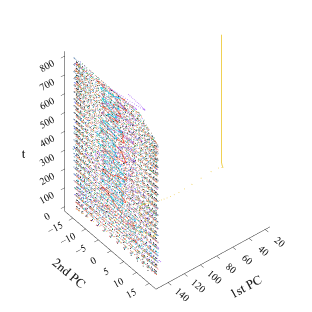

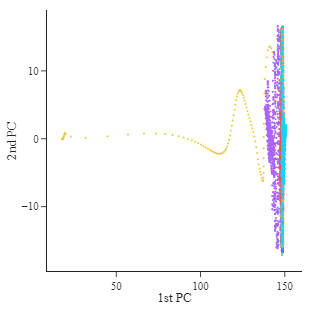

In [ ]:
fig_3d = go.Figure()
fig_2d = go.Figure()
n_T = 800

show_model_list = list(models.keys())#['Dataset']#, 'FVM_H2', 'Spectral_H2']
show_model_list = ['Dataset','H0_xy1']
names = ['Dataset', 'Spectral', 'FVM']
colors = iter(['Black','Blue','Red']) #iter(default_colors)
for i, key in enumerate(show_model_list):
    if key not in show_model_list: continue
    color_i = next(colors)
    # fig_3d.add_trace(go.Scatter3d(x=models[key]['pca_encoding'][:n_T, 0], 
    #                            y=models[key]['pca_encoding'][:n_T, 1], 
    #                            z=np.arange(n_T),
    #                            name=models[key]['name'], legendgroup=models[key]['name'],
    #                            mode='markers', marker=dict(size=0.5, color=color_i)
    #                            ))
    fig_2d.add_trace(go.Scatter(x=models[key]['pca_encoding'][:n_T, 0], 
                               y=models[key]['pca_encoding'][:n_T, 1], 
                               #z=np.arange(n_T), 
                               name=models[key]['name'], legendgroup=models[key]['name'],
                               mode='markers', marker=dict(size=2, color=color_i)
                               ))
# fig_3d.update_layout(
#     font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=False,
#     width=px_width/2, height = px_width/2, margin=dict(l=0, r=0, t=10, b=10),
#     scene=pca_scene_dict, scene_camera=pca_scene_camera
# )
fig_2d.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=False,
    width=px_width/3, height = px_width/3, margin=dict(l=10, r=10, t=10, b=10),
    xaxis={'title_text':"1st PC", 'title_standoff':1}, 
    yaxis={'title_text':"2nd PC", 'title_standoff':1},
    legend=dict(
        itemsizing="constant",   # keep legend markers same size as trace
        x=0.5, y=1,
        xanchor="center", yanchor="top",
        #xref="container",
        yref="container",
        orientation='h', tracegroupgap=0,
        bgcolor="rgba(255,255,255,0)",
        entrywidth=0.3, # change it to 0.3
        entrywidthmode='fraction',
    )
)
#fig_3d.show(renderer="png")
fig_2d.show(renderer="png")

In [116]:
sweep_run

['dauntless-sweep-10',
 'denim-sweep-4',
 'genial-sweep-12',
 'hardy-sweep-6',
 'jolly-sweep-7',
 'leafy-sweep-1',
 'restful-sweep-2',
 'rich-sweep-3',
 'rural-sweep-5',
 'scarlet-sweep-9',
 'smooth-sweep-13',
 'vocal-sweep-8',
 'volcanic-sweep-11']

In [ ]:
show_model_list = ['Dataset','H0_xy1',None]
for sweep_n in sweep_run:
    colors = iter(['Black','Blue','Red']) #iter(default_colors)
    show_model_list[-1] = sweep_n
    fig_2d = go.Figure()
    for i, key in enumerate(show_model_list):
        if key not in show_model_list: continue
        color_i = next(colors)
        fig_2d.add_trace(go.Scatter(x=models[key]['pca_encoding'][:n_T, 0], 
                                y=models[key]['pca_encoding'][:n_T, 1], 
                                #z=np.arange(n_T), 
                                name=models[key]['name'], legendgroup=models[key]['name'],
                                mode='markers', marker=dict(size=1, color=color_i)
                                ))
    fig_2d.update_layout(
        font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=False,
        width=px_width/3, height = px_width/3, margin=dict(l=10, r=10, t=10, b=10),
        xaxis={'title_text':"1st PC", 'title_standoff':1}, 
        yaxis={'title_text':"2nd PC", 'title_standoff':1},
        # legend=dict(
        #     itemsizing="constant",   # keep legend markers same size as trace
        #     x=0.5, y=1,
        #     xanchor="center", yanchor="top",
        #     #xref="container",
        #     yref="container",
        #     orientation='h', tracegroupgap=0,
        #     bgcolor="rgba(255,255,255,0)",
        #     entrywidth=0.3, # change it to 0.3
        #     entrywidthmode='fraction',
        # )
    )
    fig_2d.write_image(f"{figure_path}/lr_sweep/MNO_cylinder_PCA_2D_{sweep_n}.pdf")
    #break

In [ ]:
# fig_3d.write_image(f"{figure_path}/MNO_cylinder_dataset_PCA_3D.pdf")
# fig_2d.write_image(f"{figure_path}/MNO_cylinder_dataset_PCA_2D.pdf")

In [ ]:
show_model_list = ['Dataset', 'H1_xy1_vw1', 'H1_xy1_vw0', 'H1_xy0_vw0', 'H0_xy0', 'H0_xy1']

## Init Mesh

In [81]:
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.openfoam_utils.preload_mesh import preprocessed_OpenFOAM_mesh
from src.physics.operators import Divergence_Operator

In [82]:
def calculate_vorticity_streses(data, Re, meshFVM, batchsize=10):
    vorticity = []
    stresses = []
    dissipation = []
    T = value['data'].shape[0]
    for i in np.arange(T, step=batchsize):
        if i+batchsize > T: batchsize = T - i - 1
        sample_u = data[i:i+batchsize,...].unsqueeze(1)

        _, gradU_pred = Divergence_Operator.caclulate(meshFVM, field=sample_u)

        w = (gradU_pred[...,1] - gradU_pred[...,2]).squeeze(0) #Note these are chamges from our paper2
        vorticity.append(w)

        shear_stress = (1/Re)*(gradU_pred[...,2] + gradU_pred[...,1]).squeeze(0) #Note these are chamges from our paper2
        stresses.append(shear_stress)

        dissipations = (2/Re)*(gradU_pred[...,0]**2 + gradU_pred[...,3]**2) + (1/Re)*shear_stress**2
        dissipation.append(dissipations)

    vorticity = torch.cat(vorticity, axis=0).squeeze(1)
    stresses = torch.cat(stresses, axis=0).squeeze(1)
    dissipation = torch.cat(dissipation, axis=0).squeeze(1)
    return vorticity, stresses, dissipation

In [154]:
from scipy.stats import gaussian_kde
import numpy.random as random
def clustered_linspace(a, b, n, p=2.0):
    t = np.linspace(-1, 1, n)
    s = np.sign(t) * np.abs(t)**p
    return 0.5*(b - a)*s + 0.5*(a + b)

def density_estimation(target_metric, bin_n=50, min_v=None, max_v=None, zero_clustering=False):
    target_data= target_metric.reshape(-1)[random.permutation(len(target_metric.reshape(-1)))]
    kde = gaussian_kde(target_data, bw_method='scott')
    if min_v is not None and max_v is not None: assert min_v < max_v
    if min_v is None: min_v = target_data.min()
    if max_v is None: max_v = target_data.max()

    if zero_clustering:
        bins = clustered_linspace(min_v, max_v, bin_n, p=4)
    else:
        bins = np.linspace(min_v, max_v, bin_n)
    density = kde.evaluate(bins)
    return bins, density

In [84]:

openfoam_case = r"C:\Users\Noahc\Documents\USYD\tutorial\cylinder_mno_turb5\case.foam"
U_bc_dict = {'inlet':{ "type":'fixedValue', "value":[1,0,0]},
                'outlet':{ "type":'zeroGradient'},  
                'cylinder':{ "type":'noSlip'},
                'front':{ "type":'empty'},
                'back':{ "type":'empty'}
                }
p_bc_dict = {'inlet':{ "type":'zeroGradient' },
            'outlet':{ "type":'zeroGradient' },
            'cylinder':{ "type":'zeroGradient'},
            'front':{ "type":'empty'},
            'back':{ "type":'empty'}
            }
bc_dict = {'U':U_bc_dict, 'p':p_bc_dict}

mesh = preprocessed_OpenFOAM_mesh(openfoam_case, dim=2, bc_dict=bc_dict, device='cpu')

Found 21004 values (header expected 21004)
Found 42364 values (header expected 41652)
Found 42364 values (header expected 41652)
Found 41652 values (header expected 41652)


In [85]:
def get_tke(data):
    ux_dash = torch.mean(data[...,0], dim=1, keepdim=True) * torch.ones_like(data[...,0])
    uy_dash = torch.mean(data[...,1], dim=1, keepdim=True) * torch.ones_like(data[...,1])
    tke = 0.5 * torch.mean(ux_dash**2 + uy_dash**2, dim=1)
    return tke

## Statistics

In [ ]:
debug = False

In [126]:
n_bins = 100 #25
for key, value in models.items():
    if key not in show_model_list: continue
    vorticity, stresses, dissipation  = calculate_vorticity_streses(value['data'], Re=100000, meshFVM=mesh)
    models[key]['vorticity'] = vorticity
    models[key]['stresses'] = stresses
    models[key]['dissipation'] = dissipation
    bins, density = density_estimation(vorticity, bin_n=n_bins)
    models[key]['vorticity_bin'] = bins
    models[key]['vorticity_density'] = density
    bins, density = density_estimation(dissipation, bin_n=n_bins)
    models[key]['dissipation_bin'] = bins
    models[key]['dissipation_density'] = density
    tke = get_tke(value['data'])
    models[key]['tke'] = tke 
    bins, density = density_estimation(tke, bin_n=n_bins)
    models[key]['tke_bin'] = bins
    models[key]['tke_density'] = density

In [287]:
if debug:
    fig = make_subplots(rows=1, cols=2, column_titles=('Vorticity over Time','Vorticity Distribution'))
    t_in = 100
    colors = iter(['Black','Blue','Red'])
    for i, key in enumerate(show_model_list):
        #if key not in show_model_list: continue
        color_i = next(colors)
        fig.add_trace(go.Scatter(x=np.arange(t_in, t_in+models[key]['vorticity'].shape[0]),  y=models[key]['vorticity'].mean(dim=-1),  mode='lines', line=dict(color=color_i), showlegend=False, name=key, legendgroup=key), row=1, col=1)
        fig.add_trace(go.Scatter(x=models[key]['vorticity_bin'], y=models[key]['vorticity_density'], mode='lines', line=dict(color=color_i), name=key, legendgroup=key), row=1, col=2)
    fig.update_xaxes(title_text="time (s)", row=1, col=1); fig.update_yaxes(title_text="Vorticity", row=1, col=1)
    fig.update_xaxes(title_text="Vorticity", row=1, col=2); fig.update_yaxes(title_text="density", row=1, col=2)
    fig.show()

**Dissipation**

Your dissipation appears low because URANS resolved viscous dissipation 
Φ
‾
Φ
  is physically small at high Re=100k—most dissipation occurs in subgrid turbulent scales modeled by 
ε
ε

In [286]:
if debug:
    fig = make_subplots(rows=1, cols=2, column_titles=('Dissipation over Time','Dissipation Distribution'))
    t_in = 100
    colors = iter(['Black','Blue','Red'])
    for i, key in enumerate(show_model_list):
        #if key not in show_model_list: continue
        color_i = next(colors)
        fig.add_trace(go.Scatter(x=np.arange(t_in, t_in+models[key]['dissipation'].shape[0]),  y=models[key]['dissipation'].mean(dim=-1),  mode='lines', line=dict(color=color_i), showlegend=False, name=key, legendgroup=key), row=1, col=1)
        fig.add_trace(go.Scatter(x=models[key]['dissipation_bin'], y=models[key]['dissipation_density'], mode='lines', line=dict(color=color_i), name=key, legendgroup=key), row=1, col=2)
    fig.update_xaxes(title_text="time (s)", row=1, col=1); fig.update_yaxes(title_text="Dissipation", row=1, col=1)
    fig.update_xaxes(title_text="Dissipation", row=1, col=2); fig.update_yaxes(title_text="density", row=1, col=2)
    fig.show()

In [288]:
if debug:
    fig = make_subplots(rows=1, cols=2, column_titles=('TKE over Time','TKE Distribution'))
    t_in = 100
    colors = iter(['Black','Blue','Red'])
    for i, key in enumerate(show_model_list):
        #if key not in show_model_list: continue
        color_i = next(colors)
        fig.add_trace(go.Scatter(x=np.arange(t_in, t_in+models[key]['tke'].shape[0]),  y=models[key]['tke'],  mode='lines', line=dict(color=color_i), showlegend=False, name=key, legendgroup=key), row=1, col=1)
        fig.add_trace(go.Scatter(x=models[key]['tke_bin'], y=models[key]['tke_density'], mode='lines', line=dict(color=color_i), name=key, legendgroup=key), row=1, col=2)
    fig.update_xaxes(title_text="time (s)", row=1, col=1); fig.update_yaxes(title_text="TKE", row=1, col=1)
    fig.update_xaxes(title_text="TKE", row=1, col=2); fig.update_yaxes(title_text="density", row=1, col=2)
    fig.show()

## Figures for Download

In [155]:
n_bins = 500 #25
for key, value in models.items():
    if key not in show_model_list: continue
    bins, density = density_estimation(models[key]['vorticity'], bin_n=n_bins, zero_clustering=True)
    models[key]['vorticity_bin'] = bins
    models[key]['vorticity_density'] = density

In [274]:
fig = go.Figure()
colors = iter(default_colors) #iter(['Black','Blue','Red','Green','Purple','Yellow'])
show_model_list = ['Dataset','H0_xy1', 'restful-sweep-2']
names = ['Dataset','H<sub>0</sub>','H<sub>1</sub>']
colors = iter(['Black','Blue','Red'])
for i, key in enumerate(show_model_list):
    color_i = next(colors)
    fig.add_trace(go.Scatter(x=models[key]['vorticity_bin'], y=models[key]['vorticity_density'], mode='lines', line=dict(color=color_i, width=1), name=names[i], legendgroup=key))
    fig.add_trace(go.Scatter(x=models[key]['vorticity_bin'], y=models[key]['vorticity_density'], mode='lines', line=dict(color=color_i, width=1), name=names[i], legendgroup=key, xaxis="x2", yaxis="y2",showlegend=False))
    fig.add_trace(go.Scatter(x=models[key]['vorticity_bin'], y=models[key]['vorticity_density'], mode='lines', line=dict(color=color_i, width=1), name=names[i], legendgroup=key, xaxis="x3", yaxis="y3",showlegend=False))

fig.update_layout(
    xaxis2=dict(domain=[0.75, 0.95], anchor="y2", mirror=True, showticklabels=True, range = [-0.1,0.1]),
    yaxis2=dict(domain=[0.60, 1], anchor="x2", mirror=True, showticklabels=True, type='log', range = [0.4,0.5],showgrid=True, side='right'),
    xaxis3=dict(domain=[0.75, 0.95], anchor="y3", mirror=True, showticklabels=True, range = [2.5,4.5]),
    yaxis3=dict(domain=[0.05, 0.45], anchor="x3", mirror=True, showticklabels=True, type='log', range = [-2.6, -2.2],showgrid=True, side='right')
)

fig.add_shape(type="rect", x0=2.5, x1=4.5, y0=0.002, y1=0.008, xref="x", yref="y", line=dict(color="black", width=1), fillcolor='rgba(0,0,0,0.00)', opacity=1)
fig.add_shape(type="rect", x0=-0.5, x1=0.5, y0=2, y1=4, xref="x", yref="y", line=dict(color="black", width=1), fillcolor='rgba(0,0,0,0.00)', opacity=1)
fig.add_annotation(x=11.4, y=0.2, ax=0.45, ay=0.45, xref="x1", yref="y1", axref="x1", ayref="y1", showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=1, arrowcolor="black", text="")
fig.add_annotation(x=11.4, y=-2, ax=4.45, ay=-2.3, xref="x1", yref="y1", axref="x1", ayref="y1", showarrow=True, arrowhead=2, arrowsize=1, arrowwidth=1, arrowcolor="black", text="")

fig.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=True,
    width=px_width, height = px_width/2, margin=dict(l=10, r=10, t=10, b=10),
    xaxis={'title_text':"Vorticity", 'title_standoff':1, 'range':[-10,10], 'domain':[0, 0.7]}, 
    yaxis={'title_text':"Density", 'title_standoff':1, "type":'log','showgrid':True, 'range':[-3,1]},
    legend=dict(#itemsizing="constant",   # keep legend markers same size as trace
        x=0.02, y=0.98, xanchor="left", yanchor="top",
        orientation='v', tracegroupgap=0, yref="paper", #xref="container",
        bgcolor="rgba(255,255,255,1.0)", entrywidth=0.3, entrywidthmode='fraction',
        bordercolor="black",
        borderwidth=1
    )
)
fig.show()
fig.write_image(f"{figure_path}/MNO_Cylinder_vorticity.pdf")

In [284]:
fig = go.Figure()
colors = iter(default_colors)# iter(['Black','Blue','Red','Green','Purple','Yellow'])
colors = iter(['Black','Blue','Red'])
for i, key in enumerate(show_model_list):
    color_i = next(colors)
    fig.add_trace(go.Scatter(x=models[key]['tke_bin'], y=models[key]['tke_density'], mode='lines', line=dict(color=color_i, width=1), name=names[i], legendgroup=key))
fig.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=True,
    width=px_width, height = px_width/3, margin=dict(l=10, r=10, t=10, b=10),
    xaxis={'title_text':"TKE", 'title_standoff':1}, 
    yaxis={'title_text':"Density", 'title_standoff':1, 'showgrid':True,},
    legend=dict(#itemsizing="constant",   # keep legend markers same size as trace
        x=0.02, y=0.98, xanchor="left", yanchor="top",
        orientation='v', tracegroupgap=0, yref="paper", #xref="container",
        bgcolor="rgba(255,255,255,1.0)", entrywidth=0.3, entrywidthmode='fraction',
        bordercolor="black",
        borderwidth=1
    )
)
fig.show()
fig.write_image(f"{figure_path}/MNO_Cylinder_TKE.pdf")

### Vorticity Frequency Distribution

In [291]:
models[key]['vorticity'].shape

torch.Size([1000, 21004])

In [327]:

dt = 0.1
fs = 1/dt

fig = go.Figure()
fig.add_trace(go.Scatter(x=freq, y=spec, mode="lines"))
fig.update_layout(
    xaxis_title="Frequency [Hz]",
    yaxis_title="Amplitude"
)
fig = go.Figure()
colors = iter(default_colors)# iter(['Black','Blue','Red','Green','Purple','Yellow'])
colors = iter(['Black','Blue','Red'])
for i, key in enumerate(show_model_list):
    color_i = next(colors)
    
    N = len(models[key]['vorticity'].mean(dim=-1))
    freq = np.fft.rfftfreq(N, d=1/fs)
    spec = np.abs(np.fft.rfft(models[key]['vorticity'].mean(dim=-1))) / N
    fig.add_trace(go.Bar(x=freq, y=spec, name=names[i], legendgroup=key, marker_color=color_i, width= 0.001,)) #, mode='lines', line=dict(color=color_i, width=1)
fig.update_layout(
    font=font, template=template, plot_bgcolor='rgba(0,0,0,0)', showlegend=True,
    width=px_width, height = px_width/3, margin=dict(l=10, r=10, t=10, b=10),
    xaxis={'title_text':"Frequency (Hz)", 'title_standoff':1, 'range':[0.2,0.4]}, 
    yaxis={'title_text':"Amplitude", 'title_standoff':1, 'showgrid':True,},
    barmode="group", bargap=0.001, 
    legend=dict(#itemsizing="constant",   # keep legend markers same size as trace
        x=0.02, y=0.98, xanchor="left", yanchor="top",
        orientation='v', tracegroupgap=0, yref="paper", #xref="container",
        bgcolor="rgba(255,255,255,1.0)", entrywidth=0.3, entrywidthmode='fraction',
        bordercolor="black",
        borderwidth=1
    )
)
fig.show()
fig.write_image(f"{figure_path}/MNO_Cylinder_vorticity_freq.pdf")